## To what extent does exactly minimizing risk correspond to accurate support recovery? Does the extent of this correspondence differ between evaluation on the train vs. test set?

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path

from pyuoi.linear_model import UoI_Lasso

#### First fit to a model without correlations

In [2]:
sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)
X, X_test, y, y_test, ss = gen_data(300, 100, covariance = sigma, beta = beta)

In [3]:
uoil = UoI_Lasso(estimation_score = 'AIC')
uoil.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='AIC', fit_intercept=True, manual_penalty=2,
     max_iter=None, n_boots_est=48, n_boots_sel=48, n_lambdas=48,
     normalize=True,
     random_state=<module 'numpy.random' from '/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/numpy/random/__init__.py'>,
     selection_frac=0.9, stability_selection=1.0, warm_start=None)

#### Calculate the exact risk of incurred by each estimate, as well as the corresponding selection accuracy

In [4]:
estimates = uoil.estimates_.reshape((-1, 100))
selection_accuracies = selection_accuracy(beta.ravel(), estimates)

In [5]:
from risk import calc_KL_div

In [6]:
# Calculation of exact KL divergence
KL_divs = np.zeros(selection_accuracies.size)
for i in range(estimates.shape[0]):
    
    beta_hat = estimates[i, :]
    
    sigma_hat = np.mean((y.ravel() - X @ beta_hat.ravel())**2)
        
    KL_divs[i] = calc_KL_div(X @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))
    

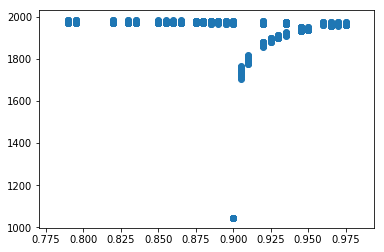

In [7]:
plt.scatter(selection_accuracies, KL_divs) 

In [8]:
# Do the same, but now use the test data to assess the KL divergence

alt_KL_divs = np.zeros(selection_accuracies.size)

for i in range(estimates.shape[0]):
    
    beta_hat = estimates[i, :]
    
    sigma_hat = np.mean((y_test.ravel() - X_test @ beta_hat.ravel())**2)
        
    alt_KL_divs[i] = calc_KL_div(X_test @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))



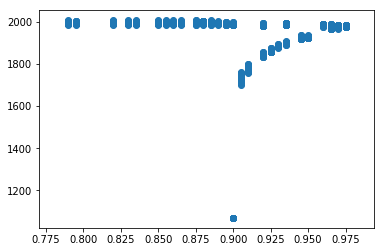

In [9]:
plt.scatter(selection_accuracies, alt_KL_divs) 

In [10]:
# The KL divergence analysis suggests that a model chosen according to the KL divergence criteria should achieve a
# selection accuracy of 0.9 What selection accuracy does the UoI procedure spit out?

In [11]:
selection_accuracy(beta.ravel(), uoil.coef_)

array([0.885])

In [12]:
## This result suggests that simply increasing the accuracy of the estimate of the KL loss will not necessarily 
# lead to better selection accuracy. Correcting bias in these procedures should therefore not necessarily be the
# goal
selection_accuracy(beta.ravel(), uoil.alt_coef_)

array([0.945])

In [ ]:
# Verify our calculation. Calculate the AIC and the true KL divergence as n -> infinity
n_samples = [300, 1000, 3000, 10000, 30000, 100000, 300000]

sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)

for i, n_samples in n_samples_:
    # Generate data
    X, X_test, y, y_test, ss = gen_data(n_samples_, 100, covariance = sigma, beta = beta)
    
    # Generate data
    